# Exam 

### imports

In [1]:
import quantkit as q
from quantkit import Compute_H_FSS_sparse, Compute_First_k_levels
import numpy as np
import matplotlib.pyplot as plt


## RYDBERG ATOM ARRAYS


Simulation of a rydberg atom array in the blockade regime

In [2]:
def generate_initial_state(L, string=True):
    # Initialize state as the "vacuum" state
    multi_partite_state = np.array([1])
    next_state = (np.array([1.,0.]), np.array([0.,1.]))

    if string:    
        for i in range(L):
            multi_partite_state = q.add_subsystem(multi_partite_state, next_state[i%2])
    else:
        for i in range(L):
            if(i==4):#4 or i == 12
                multi_partite_state = q.add_subsystem(multi_partite_state, next_state[1])
            else:
                multi_partite_state = q.add_subsystem(multi_partite_state, next_state[i%2])

    return multi_partite_state

In [3]:
Omega = 2 
delta = 0.
L     = 8
P = q.blockade_projection_matrix(L)
L_effective = P.shape[0]

H_FSS =  P @ Compute_H_FSS_sparse(Omega, delta, L) @ P.T  
H_FSS = H_FSS.todense()

initial_state = generate_initial_state(L)
perturbation = q.generate_random_state(2**L) 
initial_state = initial_state + perturbation*0.
initial_state /= np.linalg.norm(initial_state)
initial_state  = P @ initial_state 

eigenvalues, eigenvectors = np.linalg.eigh(H_FSS)

# Save eigenvalues and eigenvectors to files (optional)
np.save("eigenvalues.npy", eigenvalues)
np.save("eigenvectors.npy", eigenvectors)

# To load them later:
# eigenvalues = np.load("eigenvalues.npy")
# eigenvectors = np.load("eigenvectors.npy")

#project the initial state in energy eigenstates
C = np.ravel(eigenvectors.conj().T @ initial_state)
time_evolution = lambda t: np.ravel(q.psi_t(t, eigenvalues, eigenvectors, C, normalize=True))

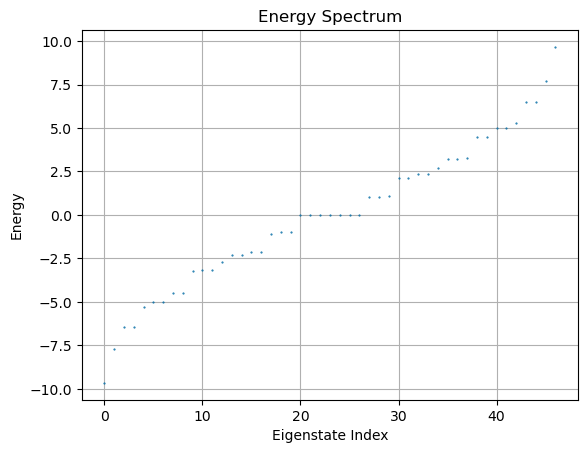

In [4]:

plt.plot(np.sort(eigenvalues), '.', markersize=1)
plt.title("Energy Spectrum")
plt.xlabel("Eigenstate Index")
plt.ylabel("Energy")
plt.grid(True)
plt.show()

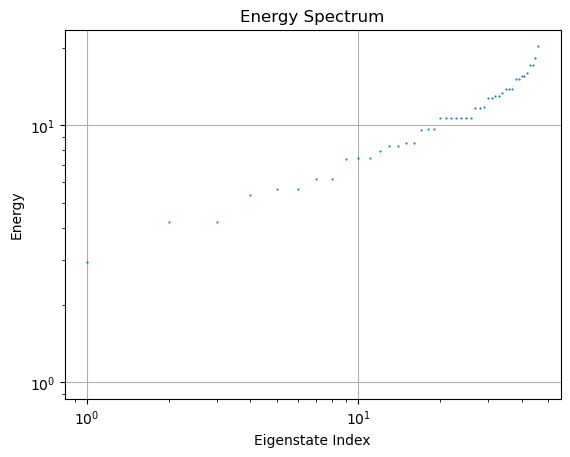

In [5]:
E = np.sort(eigenvalues)
E = E - np.min(E) + 1
plt.plot(E, '.', markersize=1)
plt.title("Energy Spectrum")
plt.xlabel("Eigenstate Index")
plt.ylabel("Energy")
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()

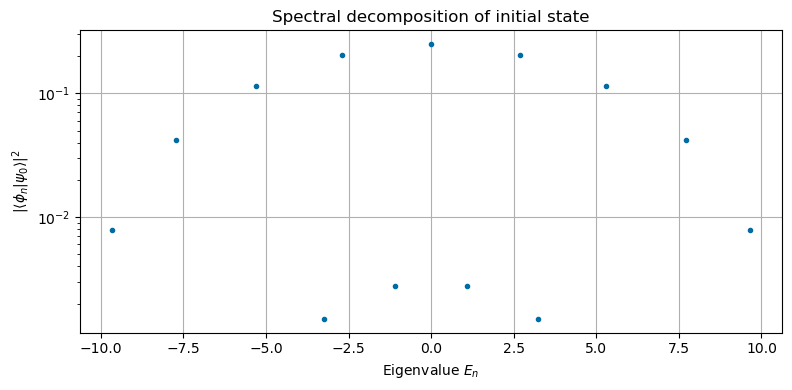

In [6]:
probabilities = np.abs(C)**2

plt.figure(figsize=(8, 4))
plt.plot(eigenvalues[probabilities>1e-15], probabilities[probabilities>1e-15], 'o', markersize=3)
plt.xlabel("Eigenvalue $E_n$")
plt.ylabel(r"$|\langle \phi_n | \psi_0 \rangle|^2$")
plt.title("Spectral decomposition of initial state")
plt.grid(True)
plt.tight_layout()
plt.yscale('log')

plt.show()

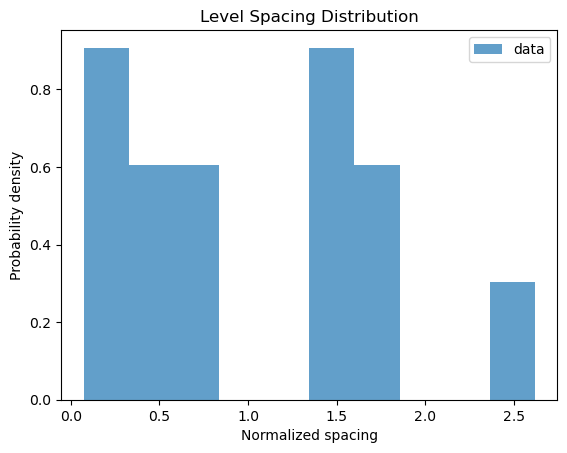

In [7]:
E = np.sort(eigenvalues)
s = np.diff(E)
s = s[s>0.01]
s = s/np.mean(s)

plt.style.use('default') 
plt.hist(s, density=True, alpha=0.7, label='data')
#plt.plot(np.linspace(0, 5, 200), 
#    np.pi/2 * np.linspace(0, 5, 200) * np.exp(-np.pi/4 * np.linspace(0, 5, 200)**2),
#    label='Wigner-Dyson', linestyle='--')
plt.title("Level Spacing Distribution")
plt.xlabel("Normalized spacing")
plt.ylabel("Probability density")
plt.legend()

plt.show()


In [8]:
t_vals = np.linspace(0, 40, 500)
psi_t  = np.array([time_evolution(t) for t in t_vals])
norms  = np.linalg.norm(psi_t, axis=-1)

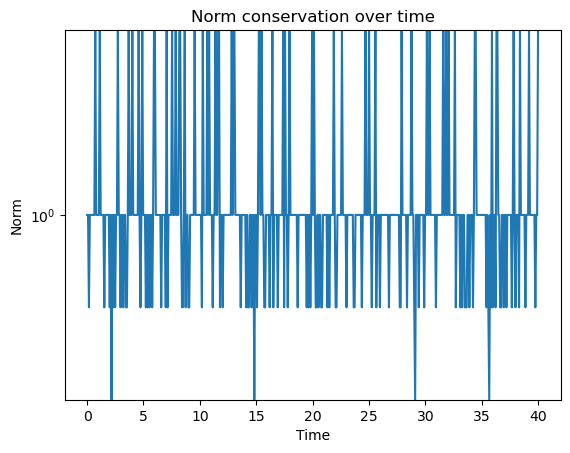

In [9]:
plt.plot(t_vals, norms)
plt.xlabel("Time")
plt.ylabel("Norm")
plt.title("Norm conservation over time")

#plt.ylim(0.95,1.05)
plt.yscale('log')
plt.show()

/home/ema/anaconda3/envs/lattice/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ema/anaconda3/envs/lattice/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


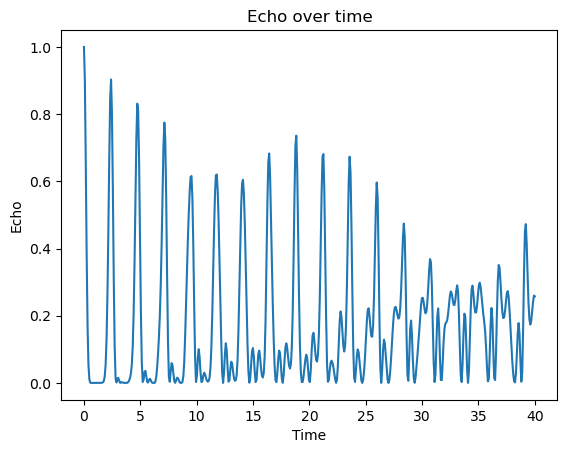

In [10]:
echo = [np.pow(initial_state.conj().T @ psi, 2) for psi in psi_t]

plt.plot(t_vals, echo)
plt.xlabel("Time")
plt.ylabel("Echo")
plt.title("Echo over time")

#plt.ylim(0.95,1.05)
#plt.yscale('log')
plt.show()

In [11]:
n_ops = [P @ operator @ P.T for operator in q.n_operators_by_site(L)]
E_ops = [P @ operator @ P.T for operator in q.E_operators_by_site(L)]

n_expectation = np.zeros((len(t_vals), L))
E_expectation = np.zeros((len(t_vals), L))

for t_idx, psi in enumerate(psi_t):
    for i in range(L):
        n_expectation[t_idx, i] = np.vdot(psi, n_ops[i] @ psi).real
        E_expectation[t_idx, i] = np.vdot(psi, E_ops[i] @ psi).real

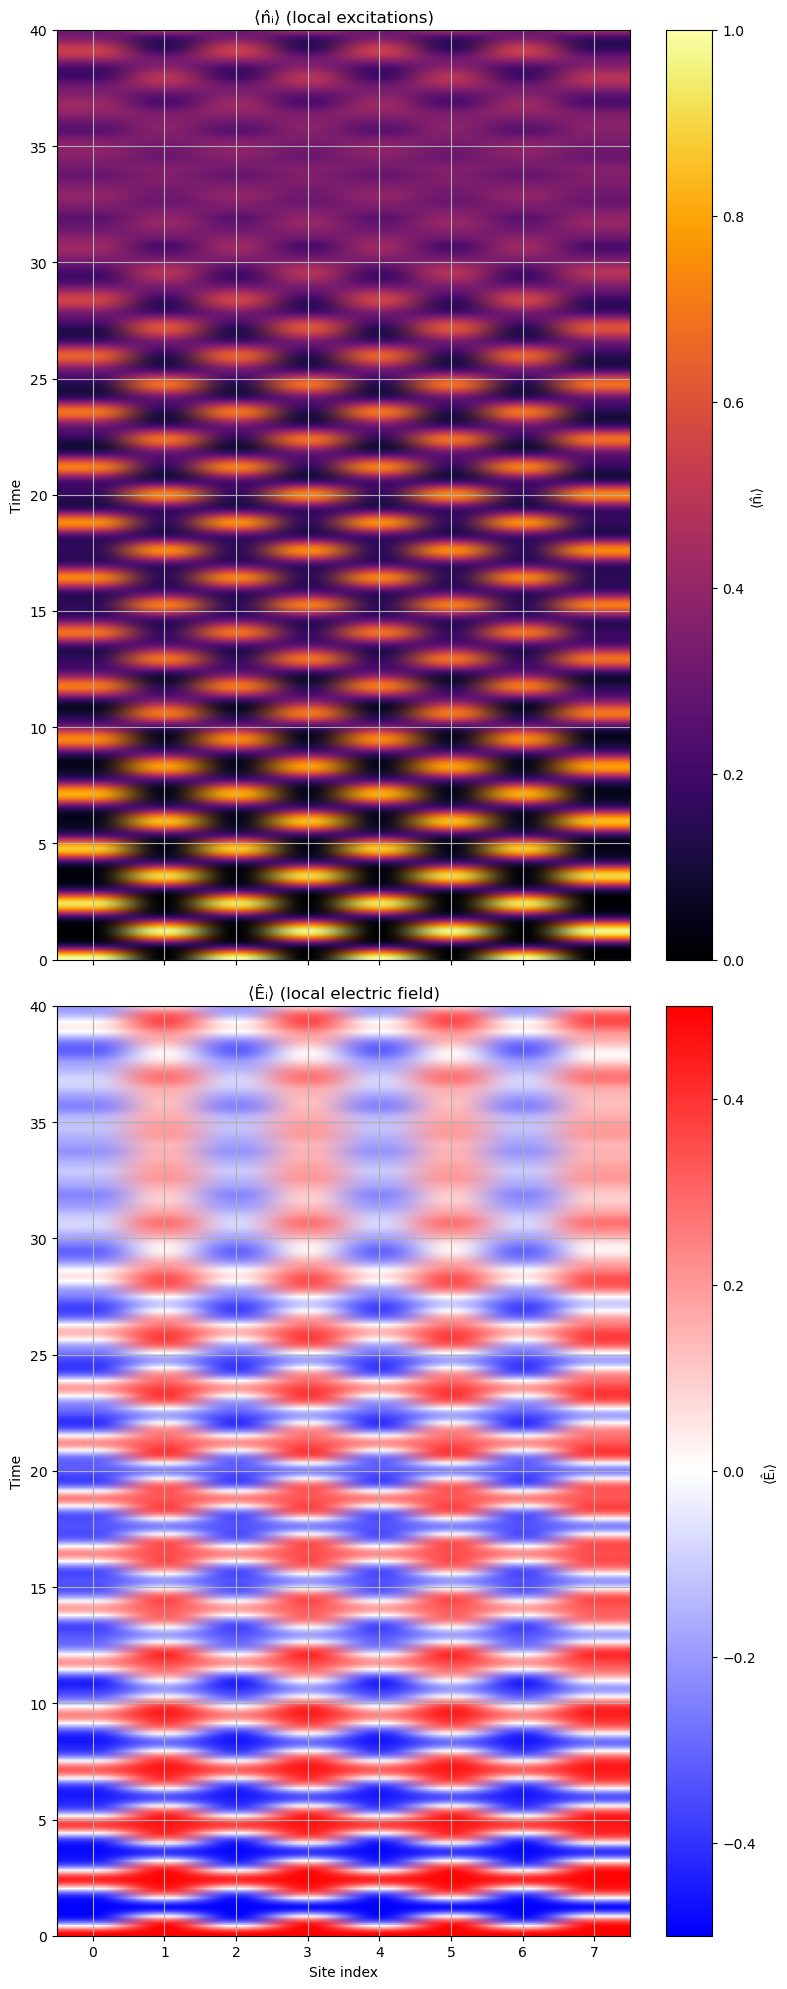

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(8, 20), sharex=True)
extent = [-0.5, L - 0.5, t_vals[0], t_vals[-1]]

# ⟨n̂_i⟩ plot: values in [0, 1]
im1 = axes[0].imshow(n_expectation, aspect='auto', origin='lower',
                     extent=extent,
                     cmap='inferno', vmin=0.0, vmax=1.0)
axes[0].set_ylabel("Time")
axes[0].set_title("⟨n̂ᵢ⟩ (local excitations)")
axes[0].grid(True)
fig.colorbar(im1, ax=axes[0], label="⟨n̂ᵢ⟩")

# ⟨Ê_i⟩ plot: values in [-0.5, 0.5]
im2 = axes[1].imshow(E_expectation, aspect='auto', origin='lower',
                     extent=extent,
                     cmap='bwr', vmin=-0.5, vmax=0.5)
axes[1].set_xlabel("Site index")
axes[1].set_ylabel("Time")
axes[1].set_title("⟨Êᵢ⟩ (local electric field)")
axes[1].grid(True)
fig.colorbar(im2, ax=axes[1], label="⟨Êᵢ⟩")

plt.tight_layout()
plt.show() 


In [13]:
print("n_expectation.shape:", n_expectation.shape)
print("E_expectation.shape:", E_expectation.shape)
print("len(t_vals):", len(t_vals))
print("L:", L)


n_expectation.shape: (500, 8)
E_expectation.shape: (500, 8)
len(t_vals): 500
L: 8


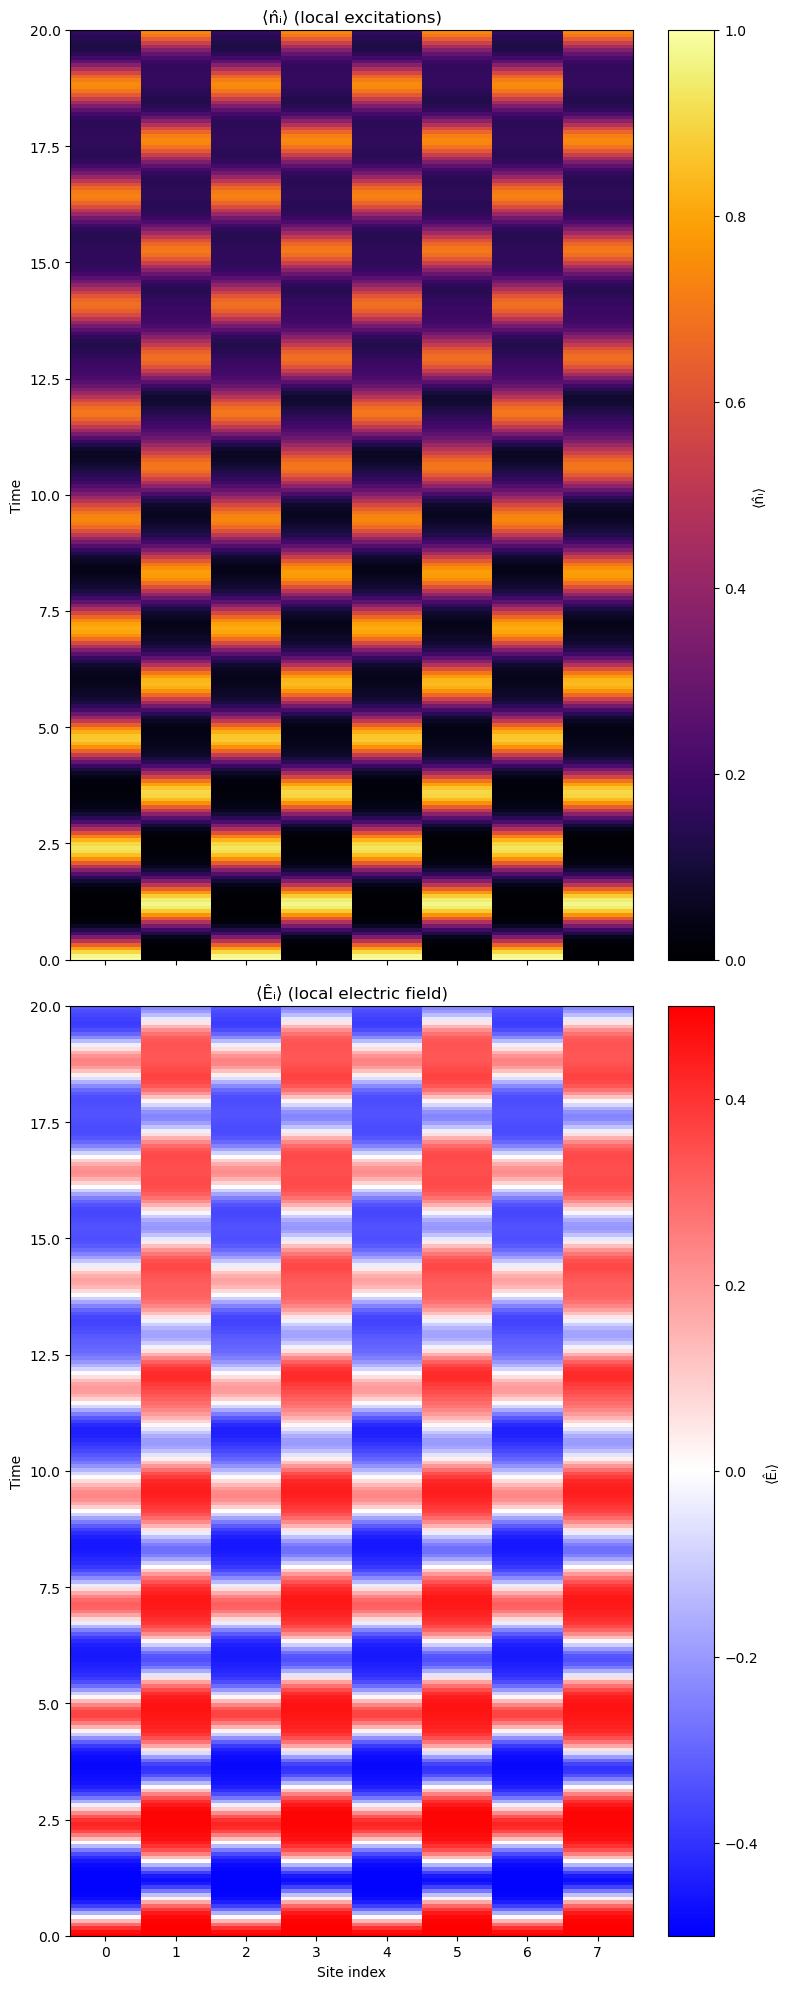

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(8, 20), sharex=True)

# X, Y grid
site_indices = np.arange(n_expectation.shape[1])
T = len(t_vals)
X, Y = np.meshgrid(site_indices, t_vals)

# ⟨n̂ᵢ⟩
c1 = axes[0].pcolormesh(X, Y, n_expectation, shading='auto', cmap='inferno', vmin=0, vmax=1)
axes[0].set_ylabel("Time")
axes[0].set_title("⟨n̂ᵢ⟩ (local excitations)")
axes[0].set_ylim([0, 20])
fig.colorbar(c1, ax=axes[0], label="⟨n̂ᵢ⟩")

# ⟨Êᵢ⟩
site_E = np.arange(E_expectation.shape[1])
X_E, Y_E = np.meshgrid(site_E, t_vals)
c2 = axes[1].pcolormesh(X_E, Y_E, E_expectation, shading='auto', cmap='bwr', vmin=-0.5, vmax=0.5)
axes[1].set_xlabel("Site index")
axes[1].set_ylabel("Time")
axes[1].set_title("⟨Êᵢ⟩ (local electric field)")
axes[1].set_ylim([0, 20])
fig.colorbar(c2, ax=axes[1], label="⟨Êᵢ⟩")

plt.tight_layout()
plt.show()


## Schwinger Model


In [15]:
def generate_initial_state_schwinger(L, string=True):
    # Initialize state as the "vacuum" state
    multi_partite_state = np.array([1])
    next_state = (np.array([1.,0.]), np.array([0.,1.]))

    if string:    
        for i in range(L):
            multi_partite_state = q.add_subsystem(multi_partite_state, next_state[(i+1)%2])
    else:
        for i in range(L):
            if(i==4):#4 or i == 12
                multi_partite_state = q.add_subsystem(multi_partite_state, next_state[1])
            else:
                multi_partite_state = q.add_subsystem(multi_partite_state, next_state[i%2])

    return multi_partite_state

w     = -Omega 
m     = -delta
J     = 1.5*w
alpha = 0.5
L_schwinger = 8


H_schwinger = q.Compute_H_schwinger_sparse(w, m, J, alpha, L_schwinger)
H_schwinger = H_schwinger.todense()

initial_state_schwinger = generate_initial_state_schwinger(L_schwinger)

eigenvalues_schwinger, eigenvectors_schwinger = np.linalg.eigh(H_schwinger)

# Save eigenvalues and eigenvectors to files (optional)
np.save("eigenvalues_schwinger.npy", eigenvalues_schwinger)
np.save("eigenvectors_schwinger.npy", eigenvectors_schwinger)

# To load them later:
# eigenvalues = np.load("eigenvalues.npy")
# eigenvectors = np.load("eigenvectors.npy")

#project the initial state in energy eigenstates
C_schwinger = np.ravel(eigenvectors_schwinger.conj().T @ initial_state_schwinger)
time_evolution_schwinger = lambda t: np.ravel(q.psi_t(t, eigenvalues_schwinger, eigenvectors_schwinger, C_schwinger, normalize=False))


plt.plot(np.sort(eigenvalues_schwinger), '.', markersize=1)
plt.title("Energy Spectrum")
plt.xlabel("Eigenstate Index")
plt.ylabel("Energy")
plt.grid(True)
plt.show()

psi_t_list_schwinger = [np.ravel(q.psi_t(t, eigenvalues_schwinger, eigenvectors_schwinger, C_schwinger)) for t in t_vals]

# --- Compute observables ---
n_ops_schwinger = q.n_operators_by_site(L_schwinger)
E_ops_schwinger = q.E_operators_by_site_schwinger(L_schwinger, alpha)

n_expectation_schwinger = np.zeros((len(t_vals), L_schwinger))
E_expectation_schwinger = np.zeros((len(t_vals), L_schwinger - 1))

for t_idx, psi in enumerate(psi_t_list_schwinger):
    for i in range(L_schwinger):
        n_expectation_schwinger[t_idx, i] = np.vdot(psi, n_ops_schwinger[i] @ psi).real
    for i in range(L_schwinger - 1):
        E_expectation_schwinger[t_idx, i] = np.vdot(psi, E_ops_schwinger[i] @ psi).real

# --- Plot ---
extent_E = [-0.5, L - 1.5, t_vals[0], t_vals[-1]]
extent_n = [-0.5, L - 0.5, t_vals[0], t_vals[-1]]

fig, axes = plt.subplots(2, 1, figsize=(8, 14), sharex=True)

im1 = axes[0].imshow(n_expectation_schwinger, aspect='auto', origin='lower',
                     extent=extent_n, cmap='inferno', vmin=0.0, vmax=1.0)
axes[0].set_ylabel("Time")
axes[0].set_title("⟨n̂ᵢ⟩ (local excitations)")
axes[0].grid(True)
fig.colorbar(im1, ax=axes[0], label="⟨n̂ᵢ⟩")

im2 = axes[1].imshow(E_expectation_schwinger, aspect='auto', origin='lower',
                     extent=extent_E, cmap='bwr', vmin=-0.5, vmax=0.5)
axes[1].set_xlabel("Link index")
axes[1].set_ylabel("Time")
axes[1].set_title("⟨Êᵢ⟩ (electric field on links)")
axes[1].grid(True)
fig.colorbar(im2, ax=axes[1], label="⟨Êᵢ⟩")

plt.tight_layout()
plt.show()

norms  = np.linalg.norm(np.array(psi_t_list_schwinger), axis=-1)
plt.plot(t_vals, norms)
plt.xlabel("Time")
plt.ylabel("Norm")
plt.title("Norm conservation over time")

#plt.ylim(0.95,1.05)
plt.yscale('log')
plt.show()

In [23]:
# --- sanity: pick parameters with J>0 ---
w      = 2.0          # hopping scale; choose sign convention you want and keep it everywhere
m      = -0.0         # mass (your call); PRX explores several regimes
J      = 1.0          # MUST be positive (∝ g^2 a / 2)
alpha  = 0.5          # background field (θ/2π); α = 0.5 is the "θ=π" case
L_s    = 8

H_sch  = q.Compute_H_schwinger_sparse(w, m, J, alpha, L_s).todense()

# initial state: Néel-like charge background (matches many Schwinger setups)
def generate_initial_state_schwinger(L):
    state = np.array([1.0])
    up, dn = np.array([1.,0.]), np.array([0.,1.])
    # Choose pattern consistent with your σ^z convention; this one alternates ↓↑↓↑...
    for i in range(L):
        state = q.add_subsystem(state, up if (i)%2==0 else dn)
    return state

psi0 = generate_initial_state_schwinger(L_s)
e_vals, e_vecs = np.linalg.eigh(H_sch)
C = np.ravel(e_vecs.conj().T @ psi0)
t_vals = np.linspace(0, 40, 500)
psi_t_list = [np.ravel(q.psi_t(t, e_vals, e_vecs, C, normalize=False)) for t in t_vals]

# observables
n_ops = q.n_operators_by_site(L_s)                     # your (σ^z+I)/2 number operators are fine
E_ops = q.E_operators_by_site_schwinger(L_s, alpha)    # corrected E_j

n_expect = np.zeros((len(t_vals), L_s))
E_expect = np.zeros((len(t_vals), L_s - 1))
for ti, psi in enumerate(psi_t_list):
    for i in range(L_s):
        n_expect[ti, i] = np.vdot(psi, (n_ops[i] @ psi)).real
    for j in range(L_s - 1):
        E_expect[ti, j] = np.vdot(psi, (E_ops[j] @ psi)).real



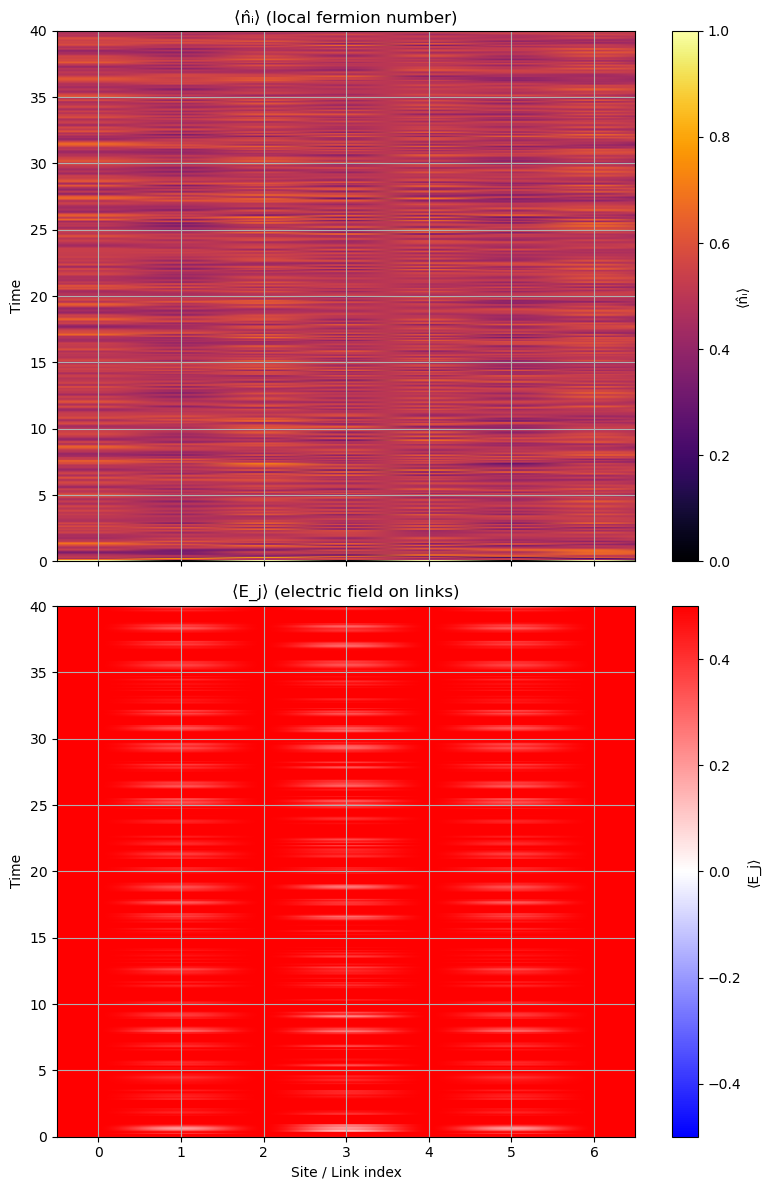

In [24]:
extent_n = [-0.5, L_s - 0.5, t_vals[0], t_vals[-1]]
extent_E = [-0.5, L_s - 1.5, t_vals[0], t_vals[-1]]

fig, axes = plt.subplots(2, 1, figsize=(8, 12), sharex=True)

# local charge density ⟨n_i⟩
im1 = axes[0].imshow(n_expect,
                     aspect='auto', origin='lower',
                     extent=extent_n, cmap='inferno',
                     vmin=0.0, vmax=1.0)
axes[0].set_ylabel("Time")
axes[0].set_title("⟨n̂ᵢ⟩ (local fermion number)")
axes[0].grid(True)
cbar1 = fig.colorbar(im1, ax=axes[0], label="⟨n̂ᵢ⟩")

# electric field ⟨E_j⟩ on links
im2 = axes[1].imshow(E_expect,
                     aspect='auto', origin='lower',
                     extent=extent_E, cmap='bwr',
                     vmin=-0.5, vmax=0.5)
axes[1].set_xlabel("Site / Link index")
axes[1].set_ylabel("Time")
axes[1].set_title("⟨E_j⟩ (electric field on links)")
axes[1].grid(True)
cbar2 = fig.colorbar(im2, ax=axes[1], label="⟨E_j⟩")

plt.tight_layout()
plt.show()

In [27]:
from scipy.sparse import dok_matrix, csr_matrix, identity, kron, vstack
sigma = [
    csr_matrix([[0, 1], [1, 0]]),  # sigma_x
    csr_matrix([[0, -1j], [1j, 0]]),  # sigma_y
    csr_matrix([[1, 0], [0, -1]])  # sigma_z
]
# --- Correct Gauss-law check ---
# E_ops[j] as defined:  E_j = α*I + 0.5 Σ_{l=0}^j (σ^z_l + (-1)^l I)
# So Gauss law is: G_j = E_j - E_{j-1} - 0.5*σ^z_j - 0.5*(-1)^j I
# with E_{-1} = 0

G_viol = np.zeros((len(t_vals), L_s))
I = identity(2**L_s, format='csr')

for ti, psi in enumerate(psi_t_list):
    for j in range(L_s):
        Ej  = E_ops[j]   if j < L_s-1 else E_ops[-1]  # at right boundary use last link
        Em1 = E_ops[j-1] if j > 0    else csr_matrix(E_ops[0].shape, dtype=np.float64)

        # Build Gauss law operator at site j
        left  = identity(2**j, format='csr') if j>0 else identity(1, format='csr')
        right = identity(2**(L_s-j-1), format='csr') if (L_s-j-1)>0 else identity(1, format='csr')
        sigma_z_j = kron(kron(left, sigma[2]), right)

        Gj = Ej - Em1 - 0.5*sigma_z_j - 0.5*((-1)**j)*I

        G_viol[ti, j] = np.real(np.vdot(psi, (Gj @ psi)))

print("Max |Gauss-law violation| over time:", np.max(np.abs(G_viol)))


Max |Gauss-law violation| over time: 0.9999999999999989
